## Using the labeling API on a mixed dataset (KDD cup '99)

This Notebook demonstrates several outlier techniques used on the KDD cup dataset, and how these results are submitted.



In [1]:
# standard library imports
import os
import sys
from collections import Counter

# pandas, seaborn etc.
import seaborn as sns
import sklearn 
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

# sklearn outlier models
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN

# other sklearn functions
from sklearn.decomposition import PCA
from sklearn.covariance import MinCovDet, EmpiricalCovariance
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# pyod
import pyod
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.knn import KNN   

sys.path.append("..") #to enable importing from ../outlierutils


Using TensorFlow backend.


In [2]:
from outlierutils import plot_top_N, plot_outlier_scores, LabelSubmitter

In [3]:
%load_ext autoreload
%autoreload 2

### Import data

In [4]:
data_path = '../data/'

In [5]:
x_kdd = pd.read_pickle(os.path.join(data_path, 'x_kdd.pkl'))
x_kdd_prepared = pd.read_pickle(os.path.join(data_path, 'x_kdd_prepared.pkl'))

y_kdd = pd.read_pickle(os.path.join(data_path, 'y_kdd.pkl'))
y_kdd_prepared = pd.read_pickle(os.path.join(data_path, 'y_kdd_prepared.pkl'))

print('Shape of the X-data: {}'.format(x_kdd.shape))
print('Shape of the prepared X-data: {}'.format(x_kdd_prepared.shape))
print('Mean of the y variable: {:.2%} (in prepared)'.format(y_kdd_prepared.mean()))

Shape of the X-data: (60839, 41)
Shape of the prepared X-data: (48113, 79)
Mean of the y variable: 0.42% (in prepared)


In [6]:
x_kdd_prepared.head()

,protocol_type = udp,protocol_type = tcp,protocol_type = icmp,service = private,service = domain_u,service = http,service = smtp,service = ftp_data,service = ftp,service = eco_i,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.062745,0.968627,1.00,0.00,0.06,0.02,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.015686,1.000000,1.00,0.00,0.25,0.02,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.145098,0.211765,0.49,0.08,0.49,0.04,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.000000,1.000000,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.000000,1.000000,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0


### Optional: Data preprocessing for the unprepared data

- Remove duplicate rows
- Remove columns with only a single value
- Make dummy columns with pd.get_dummies()
- Scale the numerical data columns


In [7]:
def data_preps(x_df, y_df):
    # Remove duplicates from X, and remove the same rows from y
    x_df = x_df.drop_duplicates(x_df.drop(columns='id').columns)
    y_df = y_df[x_df.index]
    
    # Remove columns with only a single value
    single_value_cols = x_df.nunique()[x_df.nunique()==1].index
    print('Columns with only one unique value: {}'.format(single_value_cols))
    x_df = x_df.drop(columns=single_value_cols)
    assert  x_df.nunique().min() >1, 'Columns with single value still remaining'
    print(f'{len(single_value_cols)} columns dropped')
    
    # The easiest way to get one-hot-encoded data: pd.get_dummies()
    numeric_cols = x_df.select_dtypes(float).columns # for the scaling in the next step
    object_cols = x_df.select_dtypes(object).columns
    binary_cols = x_df.nunique()[x_df.nunique() == 2].index
    numeric_cols = list(set(numeric_cols) - set(binary_cols))
    
    x_df = pd.get_dummies(x_df, drop_first=True, columns=object_cols) 
    # NB: in principle, .get_dummies() automatically uses object and category columns
    
    # TODO: implement scaling (when needed to use raw data... otherwise delete this function)
    return x_df, y_df

use_raw_data = False
if use_raw_data:
    x_kdd_prepared, y_kdd_prepared = data_preps(x_kdd, y_kdd)
    

### 1. KNN

In [8]:
# train kNN detector
first_N = 20000
clf_name = 'KNN'
clf = KNN(method='median', n_neighbors=83)
clf.fit(x_kdd_prepared.head(first_N))

# get the prediction label and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores


**Submit to the API**

In [9]:
url = "https://unsupervised-label-api-pg.herokuapp.com/"

ls_ernst = LabelSubmitter(username='ernst', 
                           password='2718_', 
                           url=url)
ls_ernst.get_jwt_token()

In [10]:
N = 500
top_N_kdd = np.argsort(y_train_scores)[::-1][:N]


In [12]:
ls_ernst.post_predictions(top_N_kdd, endpoint='kdd')

submitted 0 new points
number of positives in submission: 74
precision of submission: 14.80%


In [14]:
labels = ls_ernst.get_labels(endpoint='kdd')

number of predictions made: 500
total number of positives found: 74
total precision: 14.80%


## 2. Isolation Forest

In [15]:
ifo = IsolationForest(n_estimators=100, max_samples=1024, random_state=1, contamination=0.01, behaviour='new')
ifo.fit(x_kdd_prepared)
kdd_isof_scores = - ifo.decision_function(x_kdd_prepared)

In [16]:
ls_test = LabelSubmitter(username='test', 
                           password='2718_', 
                           url=url)
ls_test.get_jwt_token()

In [17]:
N = 500
top_N_kdd_iso = np.argsort(kdd_isof_scores)[::-1][:N]


In [18]:
ls_test.post_predictions(top_N_kdd_iso, endpoint='kdd')

submitted 0 new points
number of positives in submission: 138
precision of submission: 27.60%


,N_submitted,N_positives_found,precision
admin,24.0,1.0,4.166667
steffen,0.0,0.0,NaN
alessandro,0.0,0.0,NaN
theo,0.0,0.0,NaN
giulio,0.0,0.0,NaN
ernst,500.0,74.0,14.800000
test,824.0,159.0,19.296117


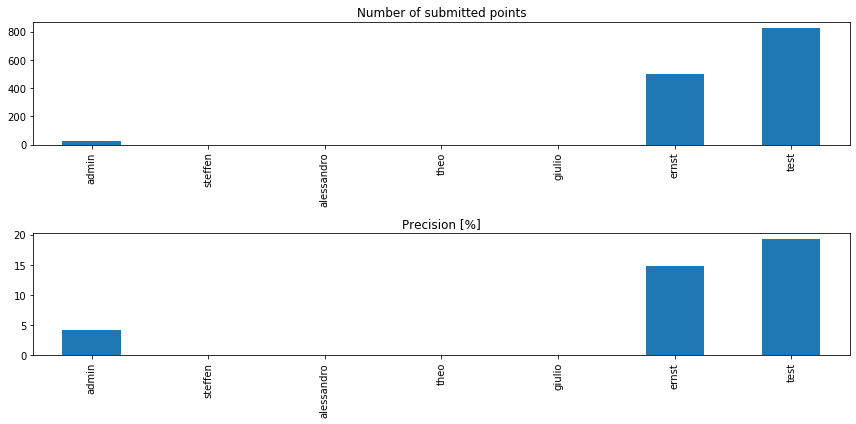

In [19]:
ls_ernst.get_statistics(endpoint='kdd')

In [21]:
ls_test.get_statistics()

{'message': 'Operation not allowed for this user'}


## 3. Autoencoder

In [22]:
x_kdd_prepared.shape

(48113, 79)

In [37]:
clf = AutoEncoder(
    hidden_neurons=[40, 20, 40],
    hidden_activation='elu',
    output_activation='linear',
    optimizer='adam',
    epochs=20,
    batch_size=16,
    dropout_rate=0.2,
    l2_regularizer=0.0,
    validation_size=0.1,
    preprocessing=True, #NB: this uses sklearn's StandardScaler (not [0, 1] --> do not use sigmoid output activation!)
    verbose=1,
    random_state=1,
    contamination=0.1,
)

In [38]:
clf.fit(x_kdd_prepared)


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 79)                6320      
_________________________________________________________________
dropout_21 (Dropout)         (None, 79)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 79)                6320      
_________________________________________________________________
dropout_22 (Dropout)         (None, 79)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 40)                3200      
_________________________________________________________________
dropout_23 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 20)               

AutoEncoder(batch_size=16, contamination=0.1, dropout_rate=0.2, epochs=20,
      hidden_activation='elu', hidden_neurons=[40, 20, 40],
      l2_regularizer=0.0,
      loss=<function mean_squared_error at 0x7fb0fe965e18>,
      optimizer='adam', output_activation='linear', preprocessing=True,
      random_state=1, validation_size=0.1, verbose=1)

In [45]:
y_train_scores = clf.decision_scores_  # raw outlier scores
y_train_scores = np.clip(y_train_scores, 0, 50)

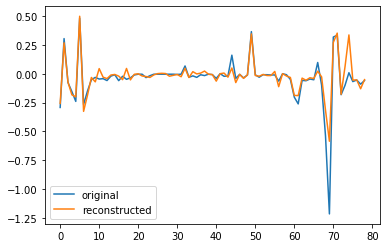

In [39]:
# Compare the original with the reconstruction to get a feeling (in StandardScaled space)
scaler = StandardScaler()
x_kdd_scaled = scaler.fit_transform(x_kdd_prepared)
x_kdd_scaled_recon = clf.model_.predict(x_kdd_scaled)
#x_kdd_recon = scaler.inverse_transform(x_kdd_scaled_recon)
plt.plot(x_kdd_scaled[0, :], label='original')
plt.plot(x_kdd_scaled_recon[0, :], label='reconstructed');
plt.legend();

In [44]:
ls_steffen = LabelSubmitter(username='steffen', 
                           password='2718_', 
                           url=url)
ls_steffen.get_jwt_token()

In [47]:
N = 500
top_N_kdd_autoenc = np.argsort(y_train_scores)[::-1][:N]
ls_steffen.post_predictions(top_N_kdd_autoenc, endpoint='kdd')

submitted 500 new points
number of positives in submission: 58
precision of submission: 11.60%


,N_submitted,N_positives_found,precision
admin,24.0,1.0,4.166667
steffen,500.0,58.0,11.600000
alessandro,0.0,0.0,NaN
theo,0.0,0.0,NaN
giulio,0.0,0.0,NaN
ernst,500.0,74.0,14.800000
test,1010.0,168.0,16.633663


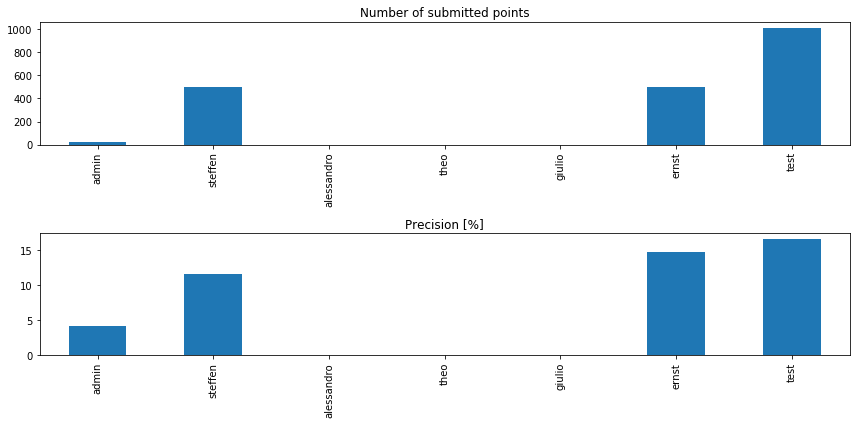

In [49]:
ls_steffen.get_statistics('kdd')

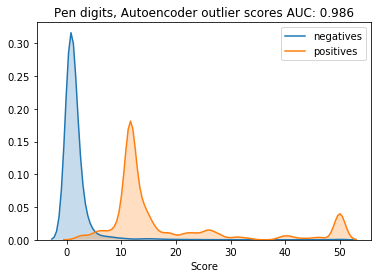

In [43]:

res = plot_outlier_scores(y_kdd_prepared.values, y_train_scores, bw=1, title='Pen digits, Autoencoder outlier scores')